# Recommender System with User and Movie Embeddings

With MovieLens 100K dataset

In [1]:
# Mount drive (for Google Colab)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model

import collections

In [3]:
base_path = 'drive/MyDrive/RecSys Embeddings/'

## Data Load and Prepatation

In [4]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(os.path.join(base_path, 'ml-100k/u.user'), sep='|', names=users_cols)
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(os.path.join(base_path, 'ml-100k/u.data'), sep='\t', names=ratings_cols)

# The movies file contains a binary feature for each genre.
genre_cols = [
    'genre_unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(os.path.join(base_path, 'ml-100k/u.item'), sep='|', names=movies_cols, encoding='latin-1')

# Let ids start from 0 + Additional FE
users['user_id'] = users['user_id'].apply(lambda x: int(x-1))
users['sex'] = users['sex'].apply(lambda x: 1 if x == 'M' else 0)
movies['movie_id'] = movies['movie_id'].apply(lambda x: int(x-1))
movies.drop(['video_release_date'], axis=1, inplace=True)
movies.drop(['imdb_url'], axis=1, inplace=True)
movies['year'] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
movies.drop(['release_date'], axis=1, inplace=True)
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: int(x-1))
ratings['user_id'] = ratings['user_id'].apply(lambda x: int(x-1))
ratings['rating'] = ratings['rating'].apply(lambda x: float(x))

# Create one merged DataFrame containing all data
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens.dropna(inplace=True)

movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,genre_unknown,Action,Adventure,Animation,Children,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),0,0,0,0,0,...,0,0,0,0,0,1997,49,1,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),0,1,1,0,0,...,0,1,0,0,0,1997,49,1,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",0,0,0,0,0,...,1,0,0,0,0,1996,49,1,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",0,0,0,0,0,...,0,0,0,0,0,1996,49,1,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",0,0,0,0,0,...,0,0,0,0,0,1994,49,1,writer,55105


In [5]:
movielens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         100000 non-null  int64  
 1   movie_id        100000 non-null  int64  
 2   rating          100000 non-null  float64
 3   unix_timestamp  100000 non-null  int64  
 4   title           100000 non-null  object 
 5   genre_unknown   100000 non-null  int64  
 6   Action          100000 non-null  int64  
 7   Adventure       100000 non-null  int64  
 8   Animation       100000 non-null  int64  
 9   Children        100000 non-null  int64  
 10  Comedy          100000 non-null  int64  
 11  Crime           100000 non-null  int64  
 12  Documentary     100000 non-null  int64  
 13  Drama           100000 non-null  int64  
 14  Fantasy         100000 non-null  int64  
 15  Film-Noir       100000 non-null  int64  
 16  Horror          100000 non-null  int64  
 17  Musical    

In [6]:
'''
user_enc = LabelEncoder()
movielens['user'] = user_enc.fit_transform(movielens['user_id'].values)

item_enc = LabelEncoder()
movielens['movie'] = item_enc.fit_transform(movielens['movie_id'].values)
'''

min_rating = min(movielens['rating'])
max_rating = max(movielens['rating'])

In [50]:
train, test = train_test_split(movielens, test_size=0.2, shuffle=True)

In [51]:
ROW_COUNT = train.shape[0]
EMBEDDING_SIZE = 8
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

## Model

In [52]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(input_dim=NUM_MOVIES, output_dim=EMBEDDING_SIZE, input_length=ROW_COUNT, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-5), name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)

    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(input_dim=NUM_USERS, output_dim=EMBEDDING_SIZE, input_length=ROW_COUNT, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-5), name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name='dot_product', normalize=True, axes=2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(128, name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2, name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(64,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2, name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(16, name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2, name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10, name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation='sigmoid') (dense_4)

    scaled_result = layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating, name='scaled_result')(result) # Scaling to [1, 5]

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], scaled_result)
    model.compile(optimizer=adam, loss='mean_absolute_error')
    return model, movie_model, user_model

In [53]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [54]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

In [55]:
history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=64,
                              epochs=50, validation_data=([test.movie_id, test.user_id],test.rating),
                              verbose=1, 
                              callbacks=callbacks)

Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.9079 - val_loss: 0.8994
Epoch 2/50
1250/1250 [==============================] - 4s 4ms/step - loss: 0.8950 - val_loss: 0.8982
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8943 - val_loss: 0.8969
Epoch 4/50
1250/1250 [==============================] - 4s 4ms/step - loss: 0.8942 - val_loss: 0.8980
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8941 - val_loss: 0.8970
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8942 - val_loss: 0.8969
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8942 - val_loss: 0.8969
Epoch 8/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8942 - val_loss: 0.8972
Epoch 9/50
1250/1250 [==============================] - 4s 4ms/step - loss: 0.8700 - val_loss: 0.8630
Epoch 10/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.782

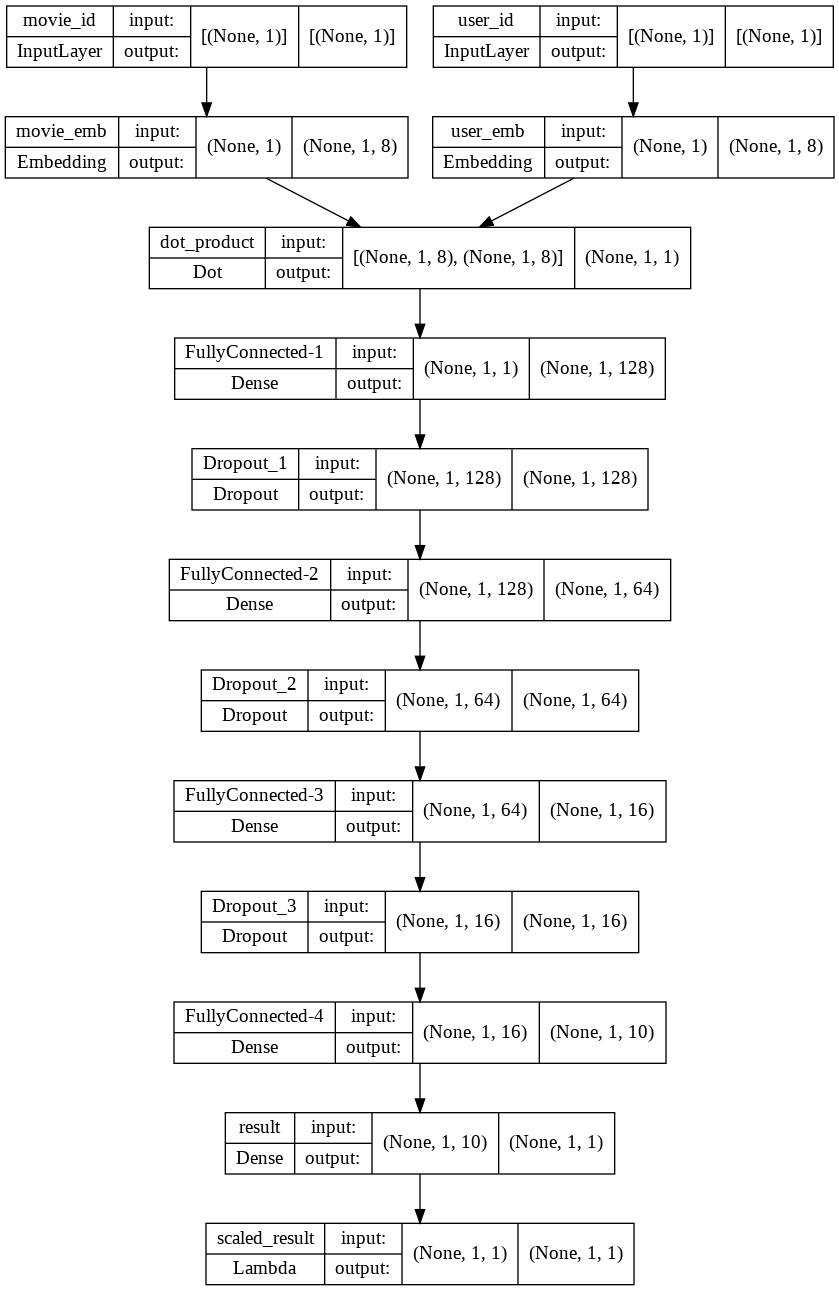

In [56]:
keras.utils.plot_model(model, show_shapes=True)

## Visualization and Evaluation

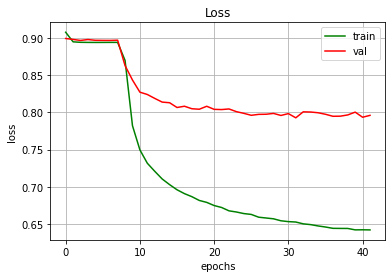

In [57]:
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'r')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


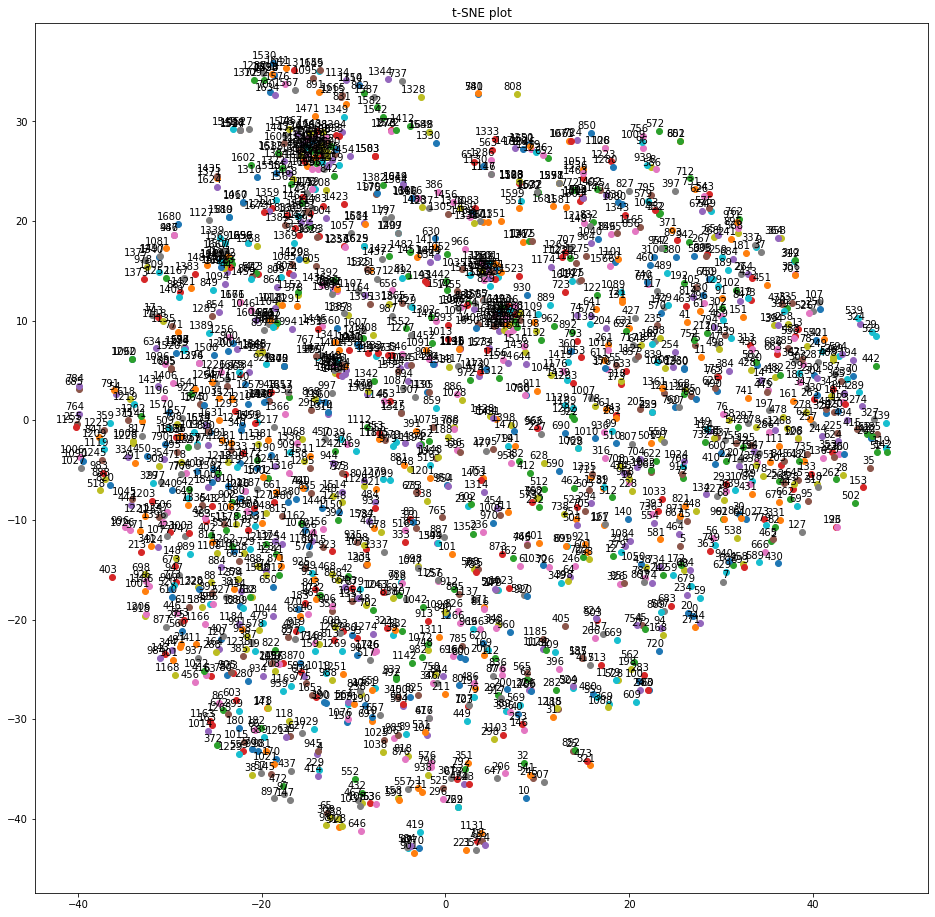

In [58]:
from sklearn.manifold import TSNE

MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

def tsne_plot(model, MOVIE_EMBEDDING_LIST, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDING_LIST[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.title('t-SNE plot')
    plt.show()

tsne_plot(model, MOVIE_EMBEDDING_LIST)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


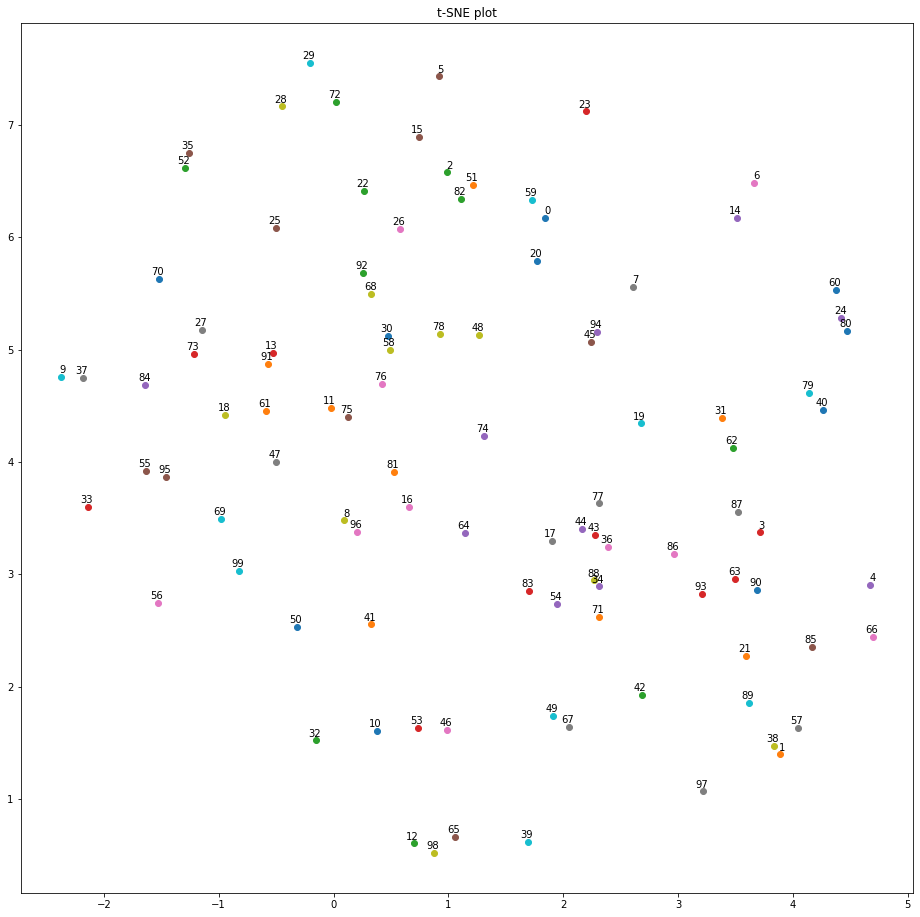

In [59]:
tsne_plot(model, MOVIE_EMBEDDING_LIST, 100)

In [63]:
np.average(movielens.loc[movielens['movie_id'] == 38, 'rating'], axis=0)

3.264367816091954

In [64]:
np.average(movielens.loc[movielens['movie_id'] == 1, 'rating'], axis=0)

3.2061068702290076

In [65]:
np.average(movielens.loc[movielens['movie_id'] == 57, 'rating'], axis=0)

3.645714285714286

## Recommendations with k-NN in Embedding Space

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn_train_label = UNIQUE_MOVIE_IDS

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

KNeighborsClassifier(n_neighbors=10)

In [67]:
def recommend_movies(embedding):
    distances, indices = knn.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']

In [69]:
# Test prediction

TEST_USER_ID = np.random.choice(NUM_USERS)

user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]
print(TEST_USER_ID)
recommend_movies(user_embedding)

413


0            English Patient, The (1996)
1             Room with a View, A (1986)
2               Wizard of Oz, The (1939)
3                    Chamber, The (1996)
4          In the Bleak Midwinter (1995)
5                  On Golden Pond (1981)
6                         Contact (1997)
7                   Grifters, The (1990)
8                    True Romance (1993)
9    Faster Pussycat! Kill! Kill! (1965)
Name: title, dtype: object

In [70]:
movielens[movielens['user_id'] == TEST_USER_ID]

,user_id,movie_id,rating,unix_timestamp,title,genre_unknown,Action,Adventure,Animation,Children,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
26439,413,301,5.0,884998953,L.A. Confidential (1997),0,0,0,0,0,...,0,0,1,0,0,1997,24,1,programmer,38115
26440,413,345,5.0,884999037,Jackie Brown (1997),0,0,0,0,0,...,0,0,0,0,0,1997,24,1,programmer,38115
26441,413,99,5.0,884999439,Fargo (1996),0,0,0,0,0,...,0,0,1,0,0,1997,24,1,programmer,38115
26442,413,287,5.0,884999066,Scream (1996),0,0,0,0,0,...,0,0,1,0,0,1996,24,1,programmer,38115
26443,413,689,4.0,884999347,Seven Years in Tibet (1997),0,0,0,0,0,...,0,0,0,1,0,1997,24,1,programmer,38115
26444,413,293,2.0,884999128,Liar Liar (1997),0,0,0,0,0,...,0,0,0,0,0,1997,24,1,programmer,38115
26445,413,263,3.0,884998993,Mimic (1997),0,0,0,0,0,...,0,1,1,0,0,1997,24,1,programmer,38115
26446,413,271,5.0,884998953,Good Will Hunting (1997),0,0,0,0,0,...,0,0,0,0,0,1997,24,1,programmer,38115
26447,413,257,5.0,884998953,Contact (1997),0,0,0,0,0,...,0,1,0,0,0,1997,24,1,programmer,38115
26448,413,747,3.0,884999147,"Saint, The (1997)",0,1,0,0,0,...,1,0,1,0,0,1997,24,1,programmer,38115
